Manuscript Associated: **New developments and comparisons of manifold-based surrogates with deep neural operators** 

Authors: 
* Katiana Kontolati, PhD Candidate, Johns Hopkins University   
* Somdatta Goswami, Postdoctoral Researcher, Brown University 
         
Last update: February 5, 2022 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate
from tqdm import tqdm
from sklearn.decomposition import PCA
from UQpy.Distributions import Uniform, Normal, JointInd
from sklearn.decomposition import KernelPCA
from sklearn import manifold
import sys
import time
sys.path.append('./utils/PCE/')
from PCE import PolyChaosExp
from PolyBasis import construct_td_basis, construct_tp_basis
from CoefficientFit import fit_lstsq, fit_lasso, fit_ridge

In [2]:
# Load data (either smooth or sharp)
# Load training and testing data
file = np.load('./data/sharp/Brusselator_data_KLE_lx_0.35_ly_0.2_v_0.15.npz') 

inputs = file['inputs']
outputs = np.array((file['outputs']))
n_samples = file['n_samples']

nx = 28
ny = 28

print('Total available data:', inputs.shape[0])

# ---------------------------------------------------------------------
# Load out-of-distribution (OOD) data
file = np.load('./data/sharp/Brusselator_data_KLE_lx_0.45_ly_0.4_v_0.15.npz')

inputs_ood = file['inputs']
outputs_ood = np.array((file['outputs']))
num_ood = file['n_samples']

print('Total available OOD data:', inputs_ood.shape[0])

Total available data: 2000
Total available OOD data: 200


In [3]:
# (Optional) Dimension reduction with PCA (check instrinsic dimensionality)
from sklearn.decomposition import PCA
X = inputs
pca = PCA(n_components=15)
pca.fit(X)
print('PCA: ', np.sum(pca.explained_variance_ratio_))

X = outputs
pca = PCA(n_components=20)
pca.fit(X)
print('PCA: ', np.sum(pca.explained_variance_ratio_))

PCA:  0.7192793107818807
PCA:  0.7048554393028894


In [4]:
# Split to train and test set
num_train = 800
num_test = 200

if num_train + num_test > n_samples:
    print('Error: The number of train and test samples should not exceed {}'.format(n_samples))

inputs_train, outputs_train = inputs[:num_train,:], outputs[:num_train,:]
inputs_test, outputs_test = inputs[num_train:(num_train+num_test),:], outputs[num_train:(num_train+num_test),:]

In [5]:
# ---------------------------------------------------------------------
#Add noise to test data (+10%) - to test, uncomment the following
# for k in range(num_test):
#     for i in range(int(nx*ny)):
#         inputs_test[k, i] = inputs_test[k, i] + np.random.normal(0,0.1*inputs_test[k, i])
        
# print('Total available noisy data:', inputs_test.shape[0])

### Dimension reduction
We perform DR on the matrix that contains train, test and OOD data.

In [6]:
# Stack train test and uniform data
data_stack_in = np.concatenate((inputs_train, inputs_test, inputs_ood))
print(data_stack_in.shape)

data_stack_out = np.concatenate((outputs_train, outputs_test, outputs_ood))
print(data_stack_out.shape)

(1200, 784)
(1200, 15680)


In [7]:
def return_error(pce, kernel_pca_out, inputs_reduced, outputs):
    # Computes L2 error and R2 score
    
    # L2
    outputs_pce = pce.predict(inputs_reduced)
    outputs_pce_ambient = kernel_pca_out.inverse_transform(outputs_pce)
    errors = np.abs(outputs_pce_ambient - outputs)
    l2_rel_err = np.linalg.norm(errors, axis=1)/np.linalg.norm(outputs, axis=1)
    l2_rel_err_mean = np.mean(l2_rel_err)

    # R2
    mean_ref = np.mean(outputs)
    r2 = 1 - (np.sum((outputs_pce_ambient - outputs) ** 2, axis=1)) / (np.sum((outputs - mean_ref) ** 2, axis=1))
    r2_mean = np.mean(r2)
    
    return l2_rel_err_mean, r2_mean, outputs_pce_ambient

In [8]:
# Number of components 
#n_comp_out = [20,25,30,35,40,45,50,55,60,65,70,75,80,85,90] # output embedding dimension
#n_comp_in = [8,12,15,20,24,28,30,32,34,36,38] # input embedding dimension
n_comp_in = [30]
n_comp_out = [45]*len(n_comp_in)
kernel = ['rbf', 'poly']

l2_outer, r2_outer,l2_outer_ood, cost = [], [], [], []
for i in range(len(n_comp_in)):

    print('Iteration:', i+1)
    print('# of input components= {}\n# of output components= {}'.format(n_comp_in[i], n_comp_out[i]))
    print('')

    start = time.time()
    
    ################ Methods #######################
    # Perform global data reduction 

    # kernel PCA (train/test/ood)
    kernel_pca_in = KernelPCA(n_components=n_comp_in[i], kernel='rbf', fit_inverse_transform=True)
    inputs_shuf_reduced = kernel_pca_in.fit_transform(data_stack_in)
        
    # Kernel PCA output
    kernel_pca_out = KernelPCA(n_components=n_comp_out[i], kernel='poly', alpha=0.3, fit_inverse_transform=True)
    outputs_shuf_reduced = kernel_pca_out.fit_transform(data_stack_out)

    finish1 = time.time() - start

    ########################################################
    # Split
    inputs_train_reduced = inputs_shuf_reduced[:num_train, :]
    inputs_test_reduced = inputs_shuf_reduced[num_train:(num_train+num_test), :]
    inputs_ood_reduced = inputs_shuf_reduced[(num_train+num_test):(num_train+num_test+num_ood), :]
    
    outputs_train_reduced = outputs_shuf_reduced[:num_train, :]
    outputs_test_reduced = outputs_shuf_reduced[num_train:(num_train+num_test), :]
    outputs_ood_reduced = outputs_shuf_reduced[(num_train+num_test):(num_train+num_test+num_ood), :]

    # PCE surrogate modeling
    # Probability distributions of input parameters
    margs = []
    for i in range(n_comp_in[i]):
        min_, max_ = np.amin(inputs_train_reduced[:,i]), np.amax(inputs_train_reduced[:,i])
        margs.append(Normal(loc=np.mean(inputs_train_reduced[:,i]), scale=np.std(inputs_train_reduced[:,i])))
        # margs.append(Uniform(loc=min_, scale=max_-min_))

    joint = JointInd(marginals=margs)

    ### PCE approximation of map between input RVs and vector-valued output
    pce_iter = 4
    pce_errors = []

    for i in range(pce_iter):

        # PCE model
        pce = PolyChaosExp(joint)
        construct_td_basis(pce, i+1)
        fit_lstsq(pce, inputs_train_reduced, outputs_train_reduced)
        #fit_ridge(pce, inputs_train_reduced, outputs_train_reduced)
        
        if False:
            print('TD-PCE order:', i+1)
            print('PCE basis size:', pce.n_polys)
            print('Condition number:', np.linalg.cond(pce.design_matrix))

        # compute validation errors
        l2_rel_err_mean, r2_mean, _ = return_error(pce, kernel_pca_out, inputs_test_reduced, outputs_test)
        
        if False:
            print('Test set mean L2 relative error:', l2_rel_err_mean)
            print('Test set R2 score:', r2_mean)
            print('')
                
        # save pce errors
        pce_errors.append(l2_rel_err_mean)

    start = time.time()
    # choose the best pce model
    get = np.argmin(pce_errors)

    # reconstruct the best pce model
    # PCE object
    pce = PolyChaosExp(joint)
    construct_td_basis(pce, get+1)
    print('Final PCE basis size:', pce.n_polys)
    fit_lstsq(pce, inputs_train_reduced, outputs_train_reduced)
    #fit_ridge(pce, inputs_train_reduced, outputs_train_reduced)

    finish2 = time.time() - start
    total_time = finish1 + finish2
    cost.append(total_time)
    
    ## compute validation errors
    l2_rel_err_mean, r2_mean, outputs_pce_ambient = return_error(pce, kernel_pca_out, inputs_test_reduced, outputs_test)
    print('Test set mean L2 relative error:', l2_rel_err_mean)
    print('Test set R2 score:', r2_mean)
    print('')
    l2_outer.append(l2_rel_err_mean)
    r2_outer.append(r2_mean)

    # Compute error for out-of-distribution (OOD) 
    l2_rel_err_ood_mean, r2_ood_mean, _ = return_error(pce, kernel_pca_out, inputs_ood_reduced, outputs_ood)
    print('OOD set mean L2 relative error:', l2_rel_err_ood_mean)
    print('OOD set R2 score:', r2_ood_mean)
    print('')
    l2_outer_ood.append(l2_rel_err_ood_mean)
        
    print('Total training time: ',total_time)


Iteration: 1
# of input components= 30
 # of output components= 45

Final PCE basis size: 496
Test set mean L2 relative error: 0.04028733627434328
Test set R2 score: 0.9162833681411624

OOD set mean L2 relative error: 0.04179859615575834
OOD set R2 score: 0.9102179195606626

Total training time:  2.187617063522339


In [9]:
print(pce.coefficients.shape)
print('Trainable parameters:', int(pce.coefficients.shape[0]*pce.coefficients.shape[1]))

(496, 45)
Trainable parameters: 22320


## Plot results

In [10]:
import os
if not os.path.exists('results'):
    os.makedirs('results')

In [11]:
# Plot error vs input dimensions
if False:
    plt.rcParams.update({'font.size': 15})
    plt.figure(figsize=(6,4.3))
    plt.plot(n_comp_in, l2_outer_ood, marker='o', c='b', label='OOD data')
    plt.plot(n_comp_in, l2_outer, marker='x', c='r', label='test data')
    plt.ticklabel_format(axis="y", scilimits=(0.03,0.055), style="sci")
    rel = r'$L_2$'
    plt.ylabel(rel+' error')
    plt.xlabel(r'$d_{in}$')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.savefig('results/mPCE-input-dim.png', dpi=500)

In [12]:
# Plot error vs output dimensions
if False:
    plt.figure(figsize=(12,4), constrained_layout='True')
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4.5))
    axes[0].plot(n_comp_out, l2_outer, c='b')
    axes[0].scatter(n_comp_out, l2_outer, c='b')
    axes[0].set_title('L2 error')
    axes[0].set_xlabel('output embedding dimension')
    axes[1].plot(n_comp_out, r2_outer, c='b')
    axes[1].scatter(n_comp_out, r2_outer, c='b')
    axes[1].set_title('R2 score')
    axes[1].set_xlabel('output embedding dimension')
    fig.tight_layout()
    plt.savefig('results/mPCE-output-dim.png', bbox_inches='tight', dpi=500)

In [17]:
# Plot input test sample, reference and prediction for 5 time steps
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
xx, yy = np.meshgrid(x, y)

index = 3
sam = inputs_test[index,:]
tot = int(nx*ny)

snapshots = 5
time = np.linspace(0,1,snapshots)
print(time)
get = np.linspace(0, outputs_test.shape[1], snapshots+1)
get = [int(x) for x in get]

[0.   0.25 0.5  0.75 1.  ]


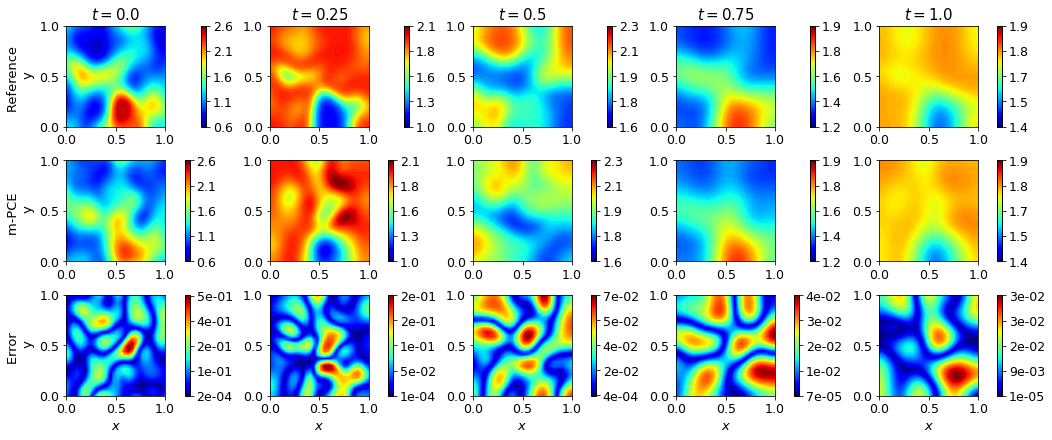

In [14]:
plt.rcParams.update({'font.size': 12.5})

fig, axs = plt.subplots(3, snapshots, figsize=(14.5,6), constrained_layout=True)
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
for col in range(snapshots):
    for row in range(3):
        th = 0.115
        ax = axs[row, col]
        if row == 0:
            if col == 3:
                th = 0.1
            ss1 = outputs_test[index, get[col]:get[col]+tot]
            pcm = ax.contourf(xx, yy, ss1.reshape(nx,ny), levels=np.linspace(np.min(ss1)-th, np.max(ss1)+th, 100), cmap='jet')
            cbar = plt.colorbar(pcm, ax=ax, aspect=50, format='%.1f', ticks=np.linspace(np.min(ss1)-th, np.max(ss1)+th , 5))
            #cbar.ax.locator_params(nbins=5)
            ax.set_title(r'$t={}$'.format(time[col]))
        if row == 1:
            if col == 3:
                th = 0.1
            ss2 = outputs_pce_ambient[index, get[col]:get[col]+tot]
            pcm = ax.contourf(xx, yy, ss2.reshape(nx,ny), levels=np.linspace(np.min(ss1)-th, np.max(ss1)+th, 100), cmap='jet')
            cbar = plt.colorbar(pcm, ax=ax, aspect=50, format='%.1f', ticks=np.linspace(np.min(ss1)-th, np.max(ss1)+th , 5))
        if row == 2:
            if col == 3:
                th = 0.1
            errors = np.abs((outputs_pce_ambient - outputs_test)/outputs_test)
            ss = errors[index, get[col]:get[col]+tot]
            pcm = ax.contourf(xx, yy, ss.reshape(nx,ny), levels=200, cmap='jet')
            plt.colorbar(pcm, ax=ax, aspect=50, format='%.0e', ticks=np.linspace(np.min(ss), np.max(ss), 5))
        if row == 2:
            ax.set_xlabel(r'$x$', fontsize=13)
        if col ==0 and row ==0:
            ax.set_ylabel('Reference \n y', fontsize=13)
        if col == 0 and row==1:
            ax.set_ylabel('m-PCE \n y', fontsize=13)
        if col == 0 and row==2:
            ax.set_ylabel('Error \n y', fontsize=13)
        ax.locator_params(axis='y', nbins=3)
        ax.locator_params(axis='x', nbins=3)
#fig.suptitle('Test realizations for 3 training realizations', fontsize=24)
plt.savefig('results/mPCE-comparison_5_timesteps.png', bbox_inches='tight', dpi=500)

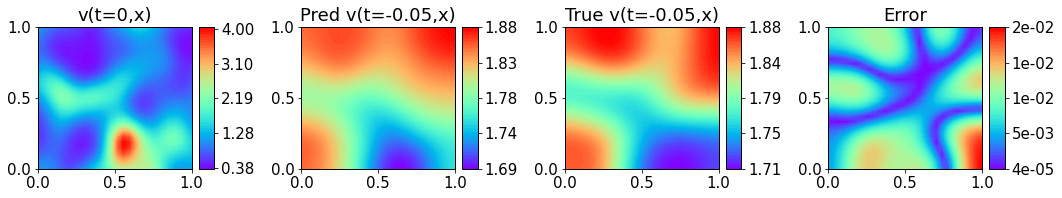

In [15]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams.update({'font.size': 15})
fig = plt.figure(figsize=(15,3))
gs = fig.add_gridspec(1,4)
plt.subplots_adjust(left = 0.1, bottom = 0.1, right = 0.9, top = 0.5, wspace = 0.4, hspace = 0.1)

ax = fig.add_subplot(gs[0,0])        
h = ax.contourf(xx, yy, inputs_test[index].reshape(nx,ny), levels=100, cmap='rainbow')
ax.set_title('v(t=0,x)')
#ax.axes.xaxis.set_visible(False)
#ax.axes.yaxis.set_visible(False)
divider = make_axes_locatable(ax)
ax.locator_params(axis='y', nbins=3)
ax.locator_params(axis='x', nbins=3)
cax = divider.append_axes("right", size="10%", pad=0.1)
fig.colorbar(h, ax=ax, cax=cax, format='%.2f', ticks=np.linspace(np.min(inputs_test[index]), np.amax(inputs_test[index]), 5))

true = outputs_test.reshape(num_test, 20, nx, ny)
pred = outputs_pce_ambient.reshape(num_test, 20, nx, ny)
tt = -1

ax = fig.add_subplot(gs[0,1])   
h = ax.contourf(xx, yy, pred[index,tt], levels=np.linspace(np.min(pred[index,tt]), np.max(pred[index,tt]), 100), cmap='rainbow')
ax.set_title('Pred v(t={},x)'.format(round(tt/20, 2)))
#ax.axes.xaxis.set_visible(False)
#ax.axes.yaxis.set_visible(False)
#        h.set_clim(vmin=0.0, vmax = 0.6)
divider = make_axes_locatable(ax)
ax.locator_params(axis='y', nbins=3)
ax.locator_params(axis='x', nbins=3)
cax = divider.append_axes("right", size="10%", pad=0.1)
fig.colorbar(h, ax=ax, cax=cax, format='%.2f', ticks=np.linspace(np.min(pred[index,tt]), np.max(pred[index,tt]), 5))

ax = fig.add_subplot(gs[0,2])

h = ax.contourf(xx, yy, true[index,tt], levels=np.linspace(np.min(true[index,tt]), np.max(true[index,tt]), 100), cmap='rainbow')
ax.set_title('True v(t={},x)'.format(round(tt/20, 2)))
#ax.axes.xaxis.set_visible(False)
#ax.axes.yaxis.set_visible(False)
#        h.set_clim(vmin=0.0, vmax = 0.6)
ax.locator_params(axis='y', nbins=3)
ax.locator_params(axis='x', nbins=3)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="10%", pad=0.1)
fig.colorbar(h, ax=ax, cax=cax, format='%.2f', ticks=np.linspace(np.min(true[index,tt]), np.max(true[index,tt]), 5))

ax = fig.add_subplot(gs[0,3])
error = np.abs((pred[index,tt] - true[index,tt])/true[index,tt])
h = ax.contourf(xx, yy, error, levels=np.linspace(np.min(error), np.amax(error), 100), cmap='rainbow')
ax.set_title('Error')
#ax.axes.xaxis.set_visible(False)
#ax.axes.yaxis.set_visible(False)        
#        h.set_clim(vmin=0, vmax=0.006)
divider = make_axes_locatable(ax)
ax.locator_params(axis='y', nbins=3)
ax.locator_params(axis='x', nbins=3)
cax = divider.append_axes("right", size="10%", pad=0.1)
fig.colorbar(h, ax=ax, cax=cax, format='%.0e', ticks=np.linspace(np.min(error), np.amax(error), 5))
plt.tight_layout()
fig.savefig('results/mPCE-comparison_final_timestep.png')